(560000, 2)
exist:279930
not exist:280070


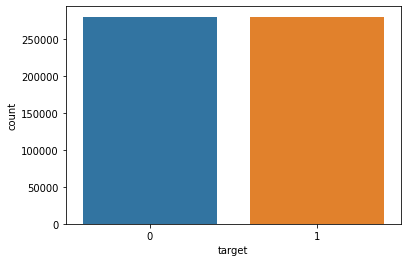

In [1]:



import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

train = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
train.head()


test = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
test.head()

sns.countplot(data=train, x="target")


print(train.shape)
num_target_exist = train["target"] == 1
# count target == 1
print("exist:{0}".format(num_target_exist.sum()))
num_target_notexist = ~(train["target"] == 1)
print("not exist:{0}".format(num_target_notexist.sum()))

def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0],  image_id[1],  image_id[2],  image_id 
    )


def visualize_sample(_id, target, colors=("black", "red", "green"), signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")):
    # visualize_train_data
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    # print(x) # show the source data
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i+1)
        plt.plot(x[i], color=colors[i])
        plt.legend([signal_names[i]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
    
    plt.subplot(4, 1, 4)
    plt.legend(signal_names, fontsize=12, loc="lower right")
    
    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show

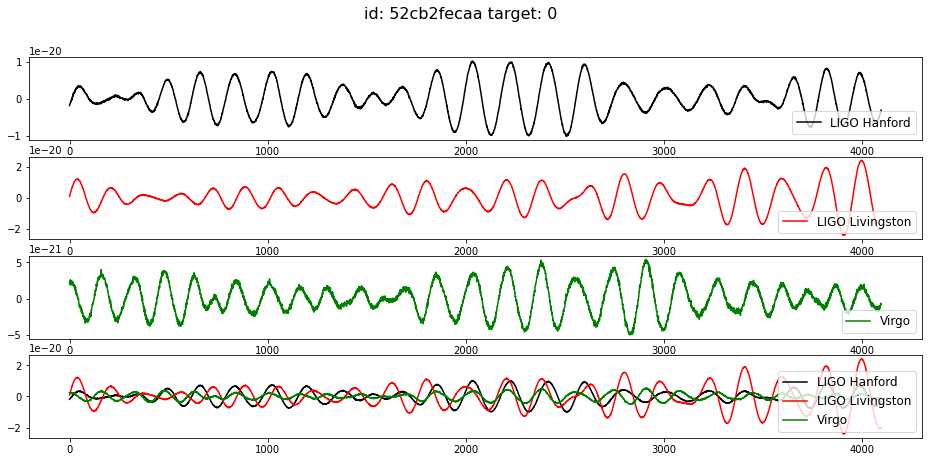

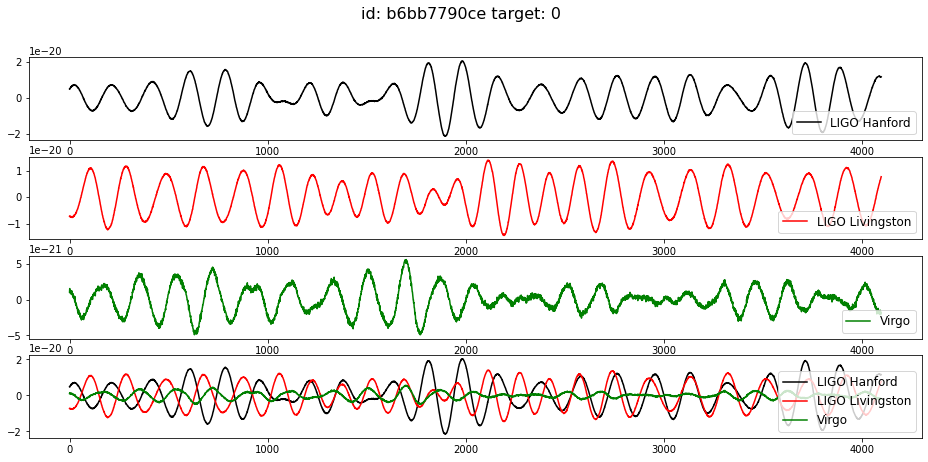

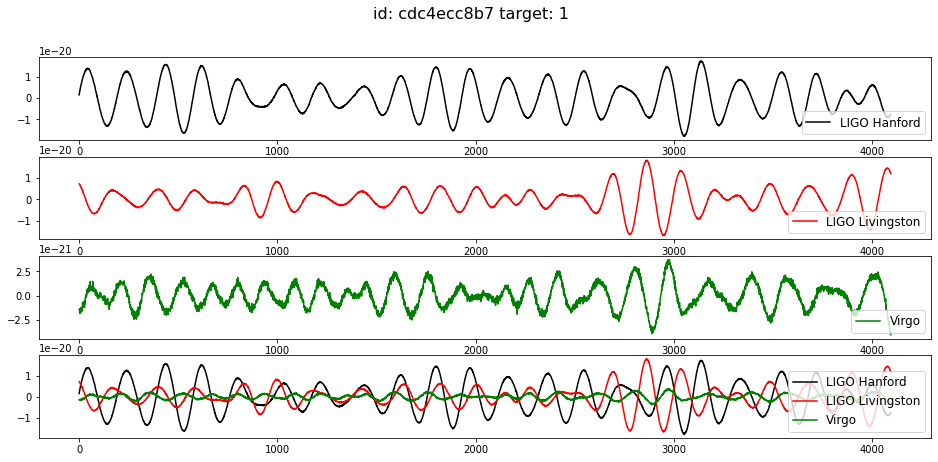

In [2]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]['id']
    target = train.iloc[i]['target']
    visualize_sample(_id, target)

import librosa
import librosa.display

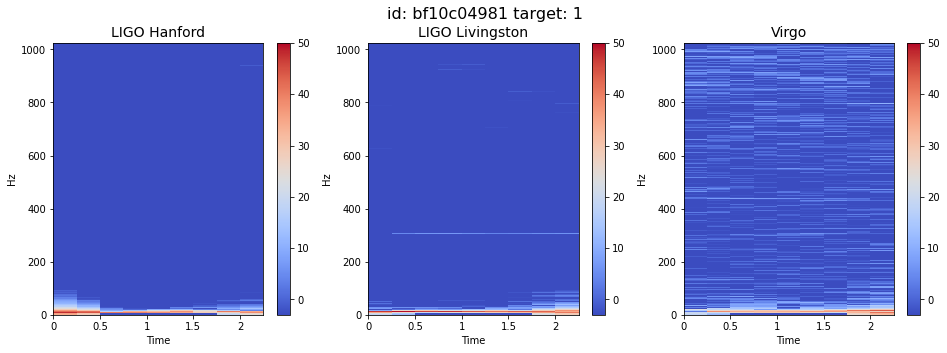

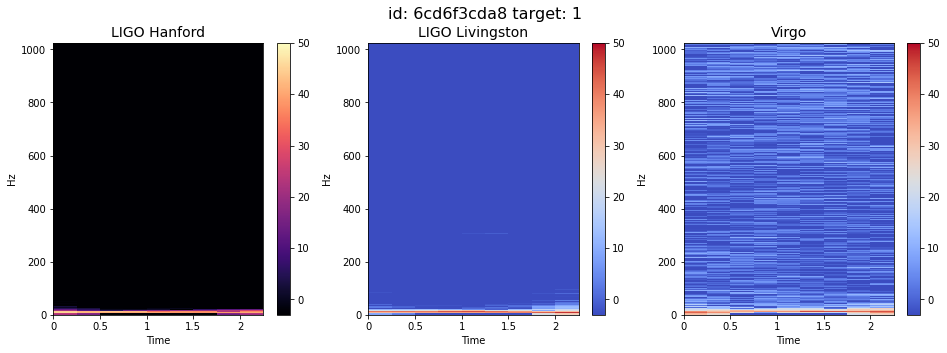

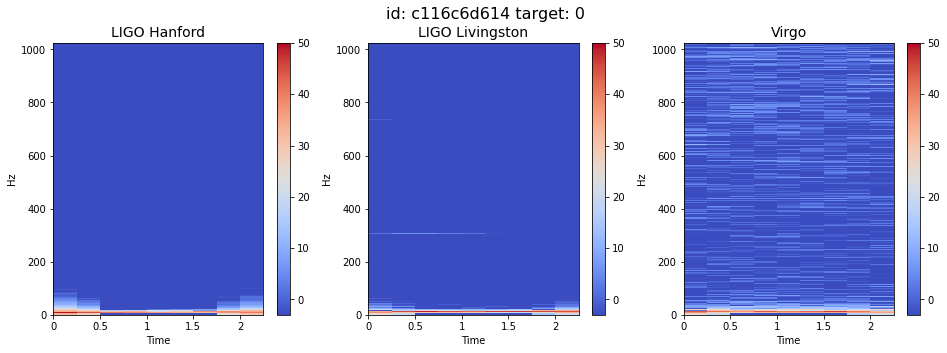

CQT kernels created, time used = 0.0215 seconds


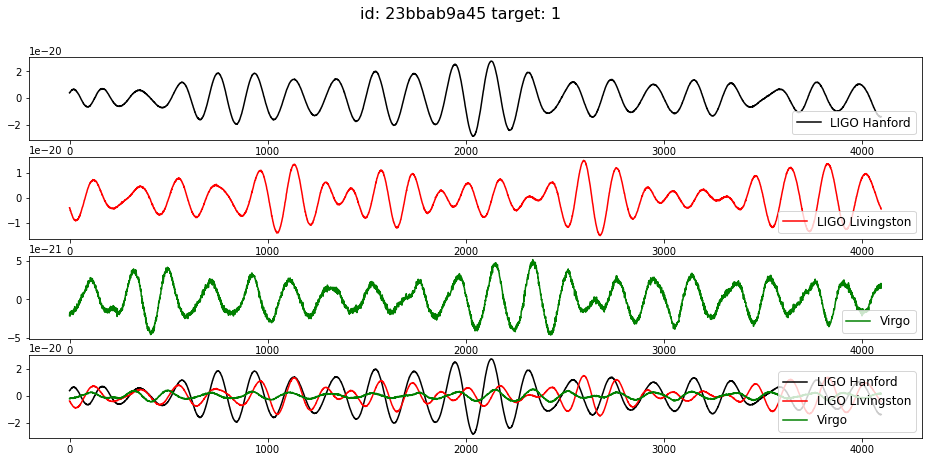

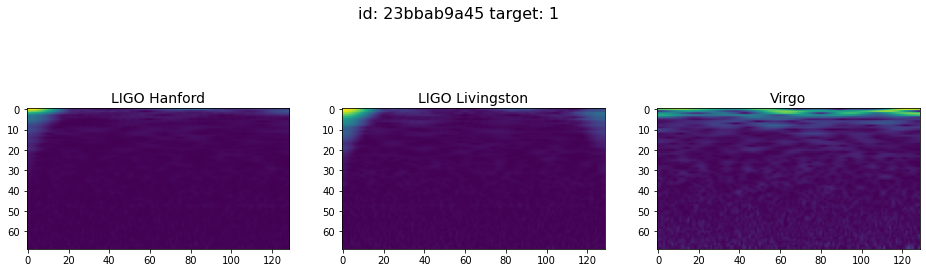

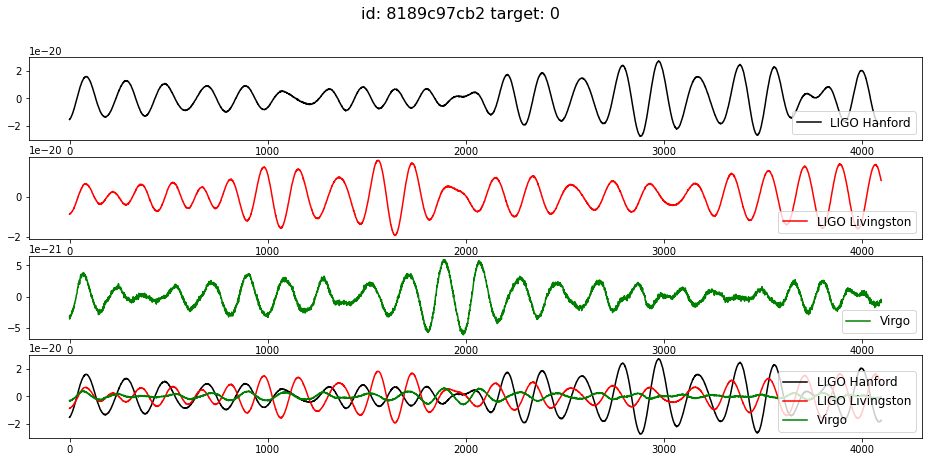

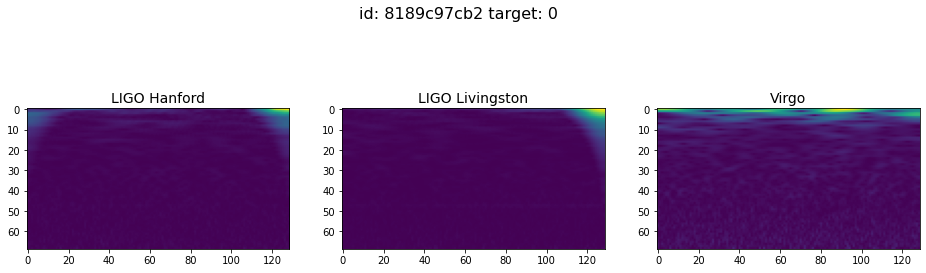

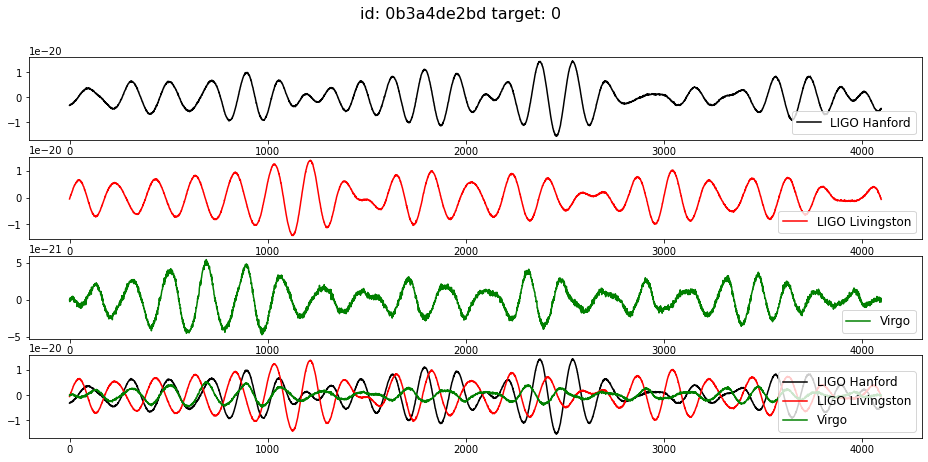

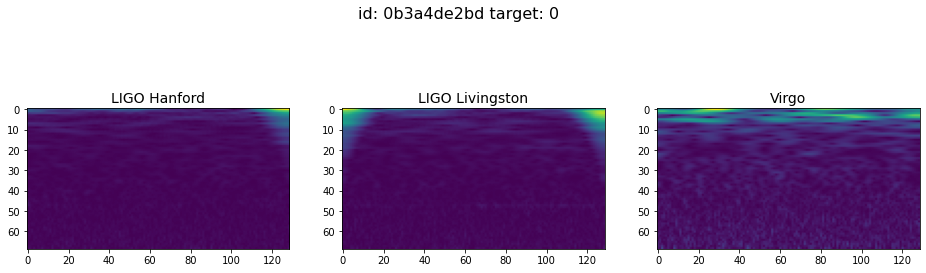

In [51]:

def visualize_sample_spectogram(_id, target, signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max()) # why x[i] / x[i].max()?
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-3, vmax=50)
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)
        
        
    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]['id']
    target = train.iloc[i]['target']
    visualize_sample_spectogram(_id, target)

!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2 # 定数Q変換を計算するための効率的なアルゴリズム

Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)

def visualize_sample_qtransform(_id, target, signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"), sr=2048):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.squeeze())
        plt.title(signal_names[i], fontsize=14)
        
    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]['id']
    target = train.iloc[i]['target']
    
    visualize_sample(_id, target)
    visualize_sample_qtransform(_id, target)

!pip install efficientnet_pytorch -qq

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torchvision.transforms.functional as F

    




import efficientnet_pytorch
from sklearn.model_selection import StratifiedKFold # 交差検証 分布に大きな不均衡がある場合に用いるKFold,  分布の比率を維持したままデータを訓練用と
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
        
        self.q_transform = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)
        
    def __len__(self):
        return len(self.paths)
    
    
    
    def __get_qtransform(self, x, y):
        image = []
        for i in range(3):
            waves = x[i] / np.max(x[i])
            waves = torch.from_numpy(waves).float()
            channel = self.q_transform(waves).squeeze().numpy()
            
            image.append(channel)
            
            out=F.resize(torch.tensor(image).float(),(64,64))
            if y==1:
                for i in range (64):
                    for j in range(64):
                        out[0:16][0:16]=out[0:16][0:16]*1
                        out[16:63][16:63]=out[0:16][16:63]
            else:
                out=out
            
            return out
    
    def __getitem__(self, index):
        # データのindexを指定すると、前処理(x: Q-Transformで画像化, y: 画像をTensor化)をして返す
        file_path = convert_image_id_2_path(self.paths[index])
        x = np.load(file_path)
        y = torch.tensor(self.targets[index], dtype=torch.float)
        image = self.__get_qtransform(x,y)
         
        
        
        y = torch.tensor(self.targets[index], dtype=torch.float)
        
        return {"X": image, "y": y}

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = efficientnet_pytorch.EfficientNet.from_pretrained("efficientnet-b7")
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, val):
        self.n += 1
        # ↓Whats?  (incremental update)
        
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg
        
        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update (unfamiliar)
        self.avg = true_count / self.n + last_n / self.n * self.avg

class Trainer:
    # do train
    def __init__(self, model, device, optimizer, criterion, loss_meter, score_meter):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = -np.inf
        self.n_patience = 0 # early_stoppingのために、止める指標 (今回は100epochでstop)
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )
            
            if True:
                # if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
            
                
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())
            
            self.optimizer.step() # update weight
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
                   
        return train_loss.avg, train_score.avg, int(time.time() - t)
            
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()
        
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}' 
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
            
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
        
    def save_model(self, n_epoch, save_path):
        torch.save(
        {
            "model_state_dict" : self.model.state_dict(),
            "optimizer_state_dict" : self.optimizer.state_dict(),
            "best_valid_score" : self.best_valid_score,
            "n_epoch" : n_epoch,
        },
        save_path
        )
    @staticmethod        
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [52]:
train_X = train.iloc[:50000]
valid_X = train.iloc[:20000]  # Reduce calculation time
print(train_X.shape, valid_X.shape)
    
train_data_retriever = DataRetriever(
    train_X["id"].values,
    train_X["target"].values
)
valid_data_retriever = DataRetriever(
    valid_X["id"].values, 
    valid_X["target"].values
)
    
train_loader = torch_data.DataLoader(train_data_retriever, batch_size=32, shuffle=True, num_workers=8)
valid_loader = torch_data.DataLoader(valid_data_retriever, batch_size=32, shuffle=False, num_workers=8)
for data in train_loader:
    print(data["y"].shape)
    print(data["X"].shape)
    print(data)
    
    
    break



(50000, 2) (20000, 2)
CQT kernels created, time used = 0.0318 seconds
CQT kernels created, time used = 0.0289 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


torch.Size([32])
torch.Size([32, 1, 64, 64])
{'X': tensor([[[[0.9037, 0.8898, 0.8531,  ..., 0.7839, 0.8213, 0.8400],
          [0.7806, 0.7526, 0.7126,  ..., 0.6029, 0.6446, 0.6672],
          [0.6471, 0.6307, 0.5902,  ..., 0.4651, 0.4964, 0.5012],
          ...,
          [0.0062, 0.0055, 0.0087,  ..., 0.0065, 0.0044, 0.0069],
          [0.0039, 0.0072, 0.0067,  ..., 0.0052, 0.0045, 0.0044],
          [0.0076, 0.0138, 0.0058,  ..., 0.0096, 0.0072, 0.0064]]],


        [[[0.0442, 0.0372, 0.0441,  ..., 0.5560, 0.5897, 0.6113],
          [0.0168, 0.0296, 0.0514,  ..., 0.5062, 0.5442, 0.5515],
          [0.1025, 0.1022, 0.1067,  ..., 0.4368, 0.4616, 0.4640],
          ...,
          [0.0103, 0.0055, 0.0080,  ..., 0.0132, 0.0057, 0.0067],
          [0.0099, 0.0088, 0.0146,  ..., 0.0164, 0.0036, 0.0074],
          [0.0117, 0.0117, 0.0195,  ..., 0.0099, 0.0046, 0.0137]]],


        [[[0.4423, 0.4203, 0.3945,  ..., 0.4291, 0.4499, 0.4617],
          [0.3562, 0.3594, 0.3352,  ..., 0.3356, 0.34

In [ ]:
!pip install efficientnet_pytorch -qq

In [5]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm



In [ ]:
class chomp1D(nn.Module):
    def __init__(self,chomp_size):
        super(chomp1D,self).__init__()
        self.chomp_size=chomp_size
    def forward(self,x):
        return x[:,:,:-self.chomp_size].contiguous()
    

In [ ]:
class temporalblock(nn.Module):
    def __init__(self,n_inputs,n_outputs,kernel_size,stride,dilation,paddling,dropout=.02):
        super(temporalblock,self).__init__()
        self.conv1=weight_norm(nn.conv1d(n_inputs,n_outputs,kernel_size,stride=stride,dilation=dilation,paddling=paddling))
        self.chomp1=chomp1D(paddling)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        
        
        self.conv2=weight_norm(nn.conv1d(n_outputs,n_outputs,kernel_size,stride=stride,dilation=dilation,paddling=paddling))
        self.chomp2=chomp1D(paddling)
        self.relu2=nn.ReLU(),
        self.dropout2=nn.Dropout(dropout)
        
        self.net=nn.sequential(self.conv1,self.chomp1,self.relu1,self.dropout1,self.conv2,self.chomp2,self.relu2,self.dropout2)
        self.downsample=nn.conv1d(n_inputs,n_outputs,1) if n_inputs != n_outputs else None
        self.relu=nn.ReLU()
        self.init_weight()
        
    def init_weight(self):
        self.conv1.weight.data.normal_(0,.01)
        self.conv2.weight.data.normal_(0,.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0,.01)
        
    def forward(self,x):
        out=self.net(x)
        res=x if self.downsample is None else  self.downsample(x)
        return  self.relu(out+res)
    
    
    
    
        
        
            
        

In [ ]:
class temporalconvnet(nn.Module):
    def __init__(self,n_inputs,num_channel,kernel_size=2,dropout=.2):
        super(temporalconvnet,self).__init__()
        
        
        layers=[]
        for i in range(len(num_channel)):
            dilation_size=2**i
            n_inputs=n_inputs if i == 0 else num_channel[i-1] 
            n_outputs=num_channel[i]
            layers+= [temporalblock(n_inputs,n_outputs,kernel_size,stride=1,dilation=dilation_size,paddling=(kernel_size-1) * dilation_size,dropout=dropout)]
        self.network =nn.Sequential(*layers)
    def  forward(self,x):
        return self.network(x)


In [ ]:
class tTcn(nn.Module):
    def __init__(self,input_size,output_size,num_channel,kernel_size,dropout):
        self(tTcn,self).__init__()
        self.tcn= temporalconvnet(input_size,num_channel,kernel_size=kernel_size,dropout=dropout)
        self.linear=nn.Linear(num_channel[-1],output_size)
        self.init_weight()
    def init_weight(self):
        self.linear.weight.data.normal_(0,.01)
    
    def forward(self,x,channel_last=True):
        y1 = self.tcn(x.transpose(1, 2) if channel_last else x)
        return self.linear(y1.transpose(1, 2))
        
        

In [ ]:
class CausalConvGenerator(nn.Module):
    def __init__(self,noise_size,output_size,n_layers,n_channel,kernel_size,dropout=0):
        super().__init__()
        
        num_channel=[n_channel]*  n_layers
        self.tcn=tTcn(noise_size, output_size, num_channel, kernel_size, dropout)
    def forward(self,x,channel_last=True):
        return torch.tanh(self.tcn(x,channel_last))

In [ ]:
class CausalConvDiscriminator(nn.Module):
    
    def __init__(self, input_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        num_channel=[n_channel]*  n_layers
        self.tcn=tTcn(input_size,1, num_channel, kernel_size, dropout)
    def forward(self,x,channel_last=True):
        return torch.sigmoid(self.tcn(x,channel_last))

In [ ]:
if __name__ == "__main__":
    #30-dimensional noise
    input = torch.randn(8,32,30)

    gen = CausalConvGenerator(noise_size=30,output_size =1,n_layers= 8,n_channel= 10,kernel_size= 8,dropout= 0)
    dis = CausalConvDiscriminator(input_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0)

    print("Input shape:", input.size())
    fake = gen(input)
    print("Generator output shape:", fake.size())
    dis_out = dis(fake)
    print("Discriminator output shape:", dis_out.size())


## Training

In [6]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, : :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv2d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
 
        self.network = nn.Sequential(*layers)

    def  forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
          self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x, channel_last=True):
        #If channel_last, the expected format is (batch_size, seq_len, features)
        y1 = self.tcn(x.transpose(1,2)  if channel_last else x)
        return self.linear(y1.transpose(1,2))


class CausalConvDiscriminator(nn.Module):
    """Discriminator using casual dilated convolution, outputs a probability for each time step
    Args:
        input_size (int): dimensionality (channels) of the input
        n_layers (int): number of hidden layers
        n_channels (int): number of channels in the hidden layers (it's always the same)
        kernel_size (int): kernel size in all the layers
        dropout: (float in [0-1]): dropout rate
        
    Input: (batch_size, seq_len, input_size)
    Output: (batch_size, seq_len, 1)
    """
    def __init__(self, input_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        #Assuming same number of channels layerwise
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(input_size, 1, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return torch.sigmoid(self.tcn(x, channel_last))

class CausalConvGenerator(nn.Module):
    """Generator using casual dilated convolution, expecting a noise vector for each timestep as input
    Args:
        noise_size (int): dimensionality (channels) of the input noise
        output_size (int): dimenstionality (channels) of the output sequence
        n_layers (int): number of hidden layers
        n_channels (int): number of channels in the hidden layers (it's always the same)
        kernel_size (int): kernel size in all the layers
        dropout: (float in [0-1]): dropout rate
        
    Input: (batch_size, seq_len, input_size)
    Output: (batch_size, seq_len, outputsize)
    """ 
    def __init__(self, noise_size, output_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(noise_size, output_size, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return torch.tanh(self.tcn(x, channel_last))


"""if __name__ == "__main__":
    #30-dimensional noise
    input = torch.randn(8, 32, 30)

    gen = CausalConvGenerator(noise_size=30, output_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0)
    dis = CausalConvDiscriminator(input_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0)

    print("Input shape:", input.size())
    fake = gen(input)
    print("Generator output shape:", fake.size())
    dis_out = dis(fake)
    print("Discriminator output shape:", dis_out.size())"""

'if __name__ == "__main__":\n    #30-dimensional noise\n    input = torch.randn(8, 32, 30)\n\n    gen = CausalConvGenerator(noise_size=30, output_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0)\n    dis = CausalConvDiscriminator(input_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0)\n\n    print("Input shape:", input.size())\n    fake = gen(input)\n    print("Generator output shape:", fake.size())\n    dis_out = dis(fake)\n    print("Discriminator output shape:", dis_out.size())'

In [7]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import datetime
#from btp_dataset import BtpDataset
#from utils import time_series_to_plot
from tensorboardX import SummaryWriter
#from models.recurrent_models import LSTMGenerator, LSTMDiscriminator
#from models.convolutional_models import CausalConvGenerator, CausalConvDiscriminator

  
#parser = argparse.ArgumentParser()
#parser.add_argument('--dataset', default="btp", help='dataset to use (only btp for now)')
""""parser.add_argument('--dataset_path', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=16, help='input batch size')
parser.add_argument('--nz', type=int, default=100, help='dimensionality of the latent vector z')
parser.add_argument('--epochs', type=int, default=50, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='checkpoints', help='folder to save checkpoints')
parser.add_argument('--imf', default='images', help='folder to save images')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--logdir', default='log', help='logdir for tensorboard')
parser.add_argument('--run_tag', default='', help='tags for the current run')
parser.add_argument('--checkpoint_every', default=5, help='number of epochs after which saving checkpoints') 
parser.add_argument('--tensorboard_image_every', default=5, help='interval for displaying images on tensorboard') 
parser.add_argument('--dis_type', default='cnn', choices=['cnn','lstm'], help='architecture to be used for discriminator to use')
parser.add_argument('--gen_type', default='lstm', choices=['cnn','lstm'], help='architecture to be used for generator to use')
opt = parser.parse_args()

#Create writer for tensorboard
date = datetime.datetime.now().strftime("%d-%m-%y_%H:%M")
run_name = f"{opt.run_tag}_{date}" if opt.run_tag != '' else date
log_dir_name = os.path.join(opt.logdir, run_name)
writer = SummaryWriter(log_dir_name)
writer.add_text('Options', str(opt), 0)
print(opt)   
    
if opt.manualSeed is None:
    
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)"""
manualSeed=999
#opt = parser.parse_args()
cudnn.benchmark = True
ngpu=1

"""if torch.cuda.is_available() and not cuda:
    print("You have a cuda device, so you might want to run with --cuda as option")
    
device = torch.device("cuda:0" if cuda else "cpu")"""
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



netD = CausalConvDiscriminator(input_size=2, n_layers=8,n_channel=8,  kernel_size=8, dropout=0).to(device)

netG = CausalConvGenerator(noise_size=101, output_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0.2).to(device)


assert netG
assert netD


criterion = nn.BCELoss().to(device)
delta_criterion = nn.MSELoss().to(device)

nz=100

fixed_noise = torch.randn(32, nz,129, device=device)

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=.002)
optimizerG = optim.Adam(netG.parameters(), lr=.002)
num_epochs=100
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        niter = epoch * len(train_loader) + i
        
        #Save just first batch of real data for displaying
        if i == 0:
            real_display = data["X"].cpu()
      
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = data["X"][:][0][0][:].to(device)
        batch_size, seq_len = 32, real.size(-1)
        print(seq_len)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)
        
       # deltas = real
        #real = torch.cat((real, deltas), dim=1)
        
        
        p=data["y"]
        targets = p.to(device)
        deltas = targets[:]
        
        real = torch.cat((real, deltas), dim=2)
        deltas = (real[:, -1] - real[:, 0]).unsqueeze(2).repeat(1, seq_len, 1)
        real = torch.cat((real, deltas), dim=2)
        
            
        output = netD(real)
        
       # output = netD(real)
        errD_real = criterion(output, label)
        print(errD_real)
        errD_real.backward()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        #Sample a delta for each batch and concatenate to the noise for each timestep
        deltas = dataset.sample_deltas(batch_size).unsqueeze(2).repeat(1, seq_len, 1)
        noise = torch.cat((noise, deltas), dim=2)

        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(torch.cat((fake.detach(), deltas), dim=2))
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        
        
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(torch.cat((fake, deltas), dim=2))
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        


129


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [54]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#dataroot,workers,batch_size,image_size,nc,nz,num_epochs,lr,beta1
ngf = 64 #Size of feature maps in generator
ndf =64  #size of featuremaps in discriminator
ngpu=1
nz=100
nc=1
lr=.02
beta1 = .5
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


#custom weights initialization  called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1 :
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
        
        
        
        
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
    
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)




class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d( nc,ndf,  4,2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)  


criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
G_losses = []
D_losses = []
iters = 0

train_X = train.iloc[:20000]
valid_X = train.iloc[:20000]  # Reduce calculation time
print(train_X.shape, valid_X.shape)
    
train_data_retriever = DataRetriever(
    train_X["id"].values,
    train_X["target"].values
)
valid_data_retriever = DataRetriever(
    valid_X["id"].values, 
    valid_X["target"].values
)
    
train_loader = torch_data.DataLoader(train_data_retriever, batch_size=32, shuffle=True, num_workers=8)
valid_loader = torch_data.DataLoader(valid_data_retriever, batch_size=32, shuffle=False, num_workers=8)
num_epochs =1
batch0 = next(iter(train_loader))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for  data in train_loader:

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        X = data["X"][:][:][:][:].to(device)
        
        
        
        
        b_size=32
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        
        
        """X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()"""
            
        output = netD(X).view(-1)
        
#output=output.squeeze(1)
        
        
        
        
        # Format batch
        #real_cpu = data["X"][:][0][0][0].to(device)
       
        #print(seq_len)
        
        
         
        
                                    
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        print(errD_real)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Random Seed:  999
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import datetime


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default="btp", help='dataset to use (only btp for now)')
parser.add_argument('--dataset_path', help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=16, help='input batch size')
parser.add_argument('--nz', type=int, default=100, help='dimensionality of the latent vector z')
parser.add_argument('--epochs', type=int, default=50, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='checkpoints', help='folder to save checkpoints')
parser.add_argument('--imf', default='images', help='folder to save images')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--logdir', default='log', help='logdir for tensorboard')
parser.add_argument('--run_tag', default='', help='tags for the current run')
parser.add_argument('--checkpoint_every', default=5, help='number of epochs after which saving checkpoints') 
parser.add_argument('--tensorboard_image_every', default=5, help='interval for displaying images on tensorboard') 
parser.add_argument('--dis_type', default='cnn', choices=['cnn','lstm'], help='architecture to be used for discriminator to use')
parser.add_argument('--gen_type', default='lstm', choices=['cnn','lstm'], help='architecture to be used for generator to use')
opt = parser.parse_args()

#Create writer for tensorboard
date = datetime.datetime.now().strftime("%d-%m-%y_%H:%M")
run_name = f"{opt.run_tag}_{date}" if opt.run_tag != '' else date
log_dir_name = os.path.join(opt.logdir, run_name)
writer = SummaryWriter(log_dir_name)
writer.add_text('Options', str(opt), 0)
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass
try:
    os.makedirs(opt.imf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("You have a cuda device, so you might want to run with --cuda as option")


    

device = torch.device("cuda:0" if opt.cuda else "cpu")
nz = int(opt.nz)
#Retrieve the sequence length as first dimension of a sequence in the dataset
seq_len = train_loader["X"][0].size(0)
#An additional input is needed for the delta
in_dim = opt.nz + 1

if opt.dis_type == "lstm": 
    netD = LSTMDiscriminator(in_dim=2, hidden_dim=256).to(device)
if opt.dis_type == "cnn":
    netD = CausalConvDiscriminator(input_size=2, n_layers=8, n_channel=10, kernel_size=8, dropout=0).to(device)
if opt.gen_type == "lstm":
    netG = LSTMGenerator(in_dim=in_dim, out_dim=1, hidden_dim=256).to(device)
if opt.gen_type == "cnn":
    netG = CausalConvGenerator(noise_size=in_dim, output_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0.2).to(device)
    
assert netG
assert netD

if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))    
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))

print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

criterion = nn.BCELoss().to(device)
delta_criterion = nn.MSELoss().to(device)

#Generate fixed noise to be used for visualization
fixed_noise = torch.randn(opt.batchSize, seq_len, nz, device=device)

#Sample both deltas and noise for visualization
deltas = dataset.sample_deltas(opt.batchSize).unsqueeze(2).repeat(1, seq_len, 1)
fixed_noise = torch.cat((fixed_noise, deltas), dim=2)

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr)

for epoch in range(opt.epochs):
    for  data  in train_loader:
        #niter = epoch * len(dataloader) + i
        
        #Save just first batch of real data for displaying
        #if i == 0:
            #r#eal_display = data.cpu()
      
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = data["X"].to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)
        
        deltas = (real[:, -1] - real[:, 0]).unsqueeze(2).repeat(1, seq_len, 1)
        real = torch.cat((real, deltas), dim=2)
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        #Sample a delta for each batch and concatenate to the noise for each timestep
        deltas = dataset.sample_deltas(batch_size).unsqueeze(2).repeat(1, seq_len, 1)
        noise = torch.cat((noise, deltas), dim=2)

        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(torch.cat((fake.detach(), deltas), dim=2))
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        #Visualize discriminator gradients
        for name, param in netD.named_parameters():
            writer.add_histogram("DiscriminatorGradients/{}".format(name), param.grad, niter)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(torch.cat((fake, deltas), dim=2))
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        
        #Visualize generator gradients
        for name, param in netG.named_parameters():
            writer.add_histogram("GeneratorGradients/{}".format(name), param.grad, niter)
        
        ###########################
        # (3) Supervised update of G network: minimize mse of input deltas and actual deltas of generated sequences
        ###########################

        #Report metrics
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, opt.epochs, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
        print()
        writer.add_scalar('DiscriminatorLoss', errD.item(), niter)
        writer.add_scalar('GeneratorLoss', errG.item(), niter)
        writer.add_scalar('D of X', D_x, niter) 
        writer.add_scalar('D of G of z', D_G_z1, niter)
        
    ##### End of the epoch #####
    real_plot = time_series_to_plot(dataset.denormalize(real_display))
    if (epoch % opt.tensorboard_image_every == 0) or (epoch == (opt.epochs - 1)):
        writer.add_image("Real", real_plot, epoch)
    
    fake = netG(fixed_noise)
    fake_plot = time_series_to_plot(dataset.denormalize(fake))
    torchvision.utils.save_image(fake_plot, os.path.join(opt.imf, opt.run_tag+'_epoch'+str(epoch)+'.jpg'))
    if (epoch % opt.tensorboard_image_every == 0) or (epoch == (opt.epochs - 1)):
        writer.add_image("Fake", fake_plot, epoch)
                             
    # Checkpoint
    if (epoch % opt.checkpoint_every == 0) or (epoch == (opt.epochs - 1)):
        torch.save(netG, '%s/%s_netG_epoch_%d.pth' % (opt.outf, opt.run_tag, epoch))
        torch.save(netD, '%s/%s_netD_epoch_%d.pth' % (opt.outf, opt.run_tag, epoch))


### choice best model

In [ ]:
models = []
for i in range(2):
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(f"best-model-{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    models.append(model)

### Prepare testdata

In [ ]:
class DataRetriever(torch_data.Dataset):
    def __init__(self, paths):
        self.paths = paths

        self.q_transform = CQT1992v2(
            sr=2048, fmin=20, fmax=1024, hop_length=32
        )
    
    def __len__(self):
        return len(self.paths)
    
    def __get_qtransform(self, x):
        image = []
        for i in range(3):
            waves = x[i] / np.max(x[i])
            waves = torch.from_numpy(waves).float() # numpy to tensor
            channel = self.q_transform(waves).squeeze().numpy() # .numpy() :This implicitly means that the converted tensor will be now processed on the CPU.
            image.append(channel)
        
        return torch.tensor(image).float()
    
    def __getitem__(self, index):
        file_path = convert_image_id_2_path(self.paths[index], is_train=False)
        x = np.load(file_path)
        image = self.__get_qtransform(x)
        
        return {"X": image, "id": self.paths[index]}

In [ ]:
test_data_retriever = DataRetriever(
    test["id"].values,
)

test_loader = torch_data.DataLoader(
    test_data_retriever,
    batch_size=32,
    shuffle=False,
    num_workers = 8
)

### Inference

In [ ]:
y_pred = []
ids = []

for e, batch in enumerate(test_loader):
    print(f"{e}/{len(test_loader)}", end="\r")
    with torch.no_grad():
        tmp_pred = np.zeros((batch["X"].shape[0], ))
        for model in models:
            tmp_res = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            tmp_pred += tmp_res / 2
        y_pred.extend(tmp_pred)
        ids.extend(batch["id"])

## Submission

In [ ]:
submission = pd.DataFrame({"id": ids, "target": y_pred})
submission.to_csv("model_submission.csv", index=False)

In [ ]:
submission